## Import Libraries

In [1]:
import tensorflow as tf # type: ignore
from tensorflow.keras import layers, models, callbacks # type: ignore
import keras_tuner as kt # type: ignore

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Exploration

In [2]:
# EDA on unclean dataset
unclean_train_dir = "../Dataset Part A - Unclean/train"
unclean_val_dir = "../Dataset Part A - Unclean/validation"
unclean_test_dir = "../Dataset Part A - Unclean/test"

In [3]:
# Create a function to load the dataset, convert it to grayscale and resize it to the target size
def load_dataset(data_dir, target_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),  # Load original size first
        batch_size=32,
        label_mode="int",  # or 'categorical' if needed
        shuffle=True,
    )

    # Convert RGB to grayscale and resize to target size
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        return image, label

    dataset = dataset.map(preprocess)
    return dataset

In [4]:
# Create datasets for both sizes
unclean_train_23 = load_dataset(unclean_train_dir, (23,23))
unclean_val_23 = load_dataset(unclean_val_dir, (23,23))
unclean_test_23 = load_dataset(unclean_test_dir, (23,23))

unclean_train_101 = load_dataset(unclean_train_dir, (101,101))
unclean_val_101 = load_dataset(unclean_val_dir, (101,101))
unclean_test_101 = load_dataset(unclean_test_dir, (101,101))

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [5]:
# Load just the class names without processing images
unclean_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unclean_train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

unclean_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unclean_test_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

unclean_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unclean_val_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(unclean_train_ds.class_names)
print(unclean_test_ds.class_names)
print(unclean_val_ds.class_names)

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum (apparently)', 'Carrot and Radish', 'Potato', 'Pumpkin (purportedly)', 'Tomato (ostensibly)']
['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower with Broccoli', 'Cucumber with Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish with Carrot', 'Tomato']


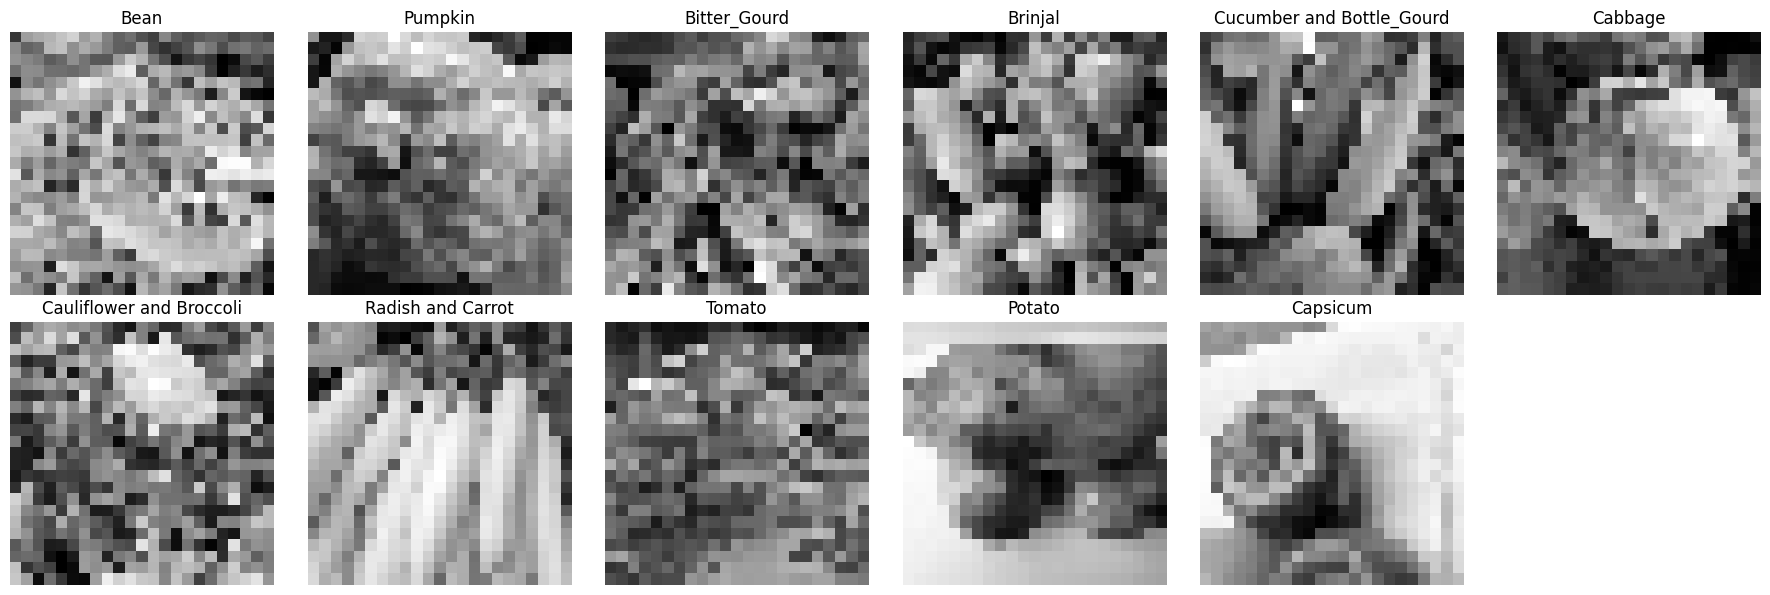

In [6]:
# Show one sample from each class in the unclean training set (23x23) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(unclean_train_23, unclean_train_ds.class_names)

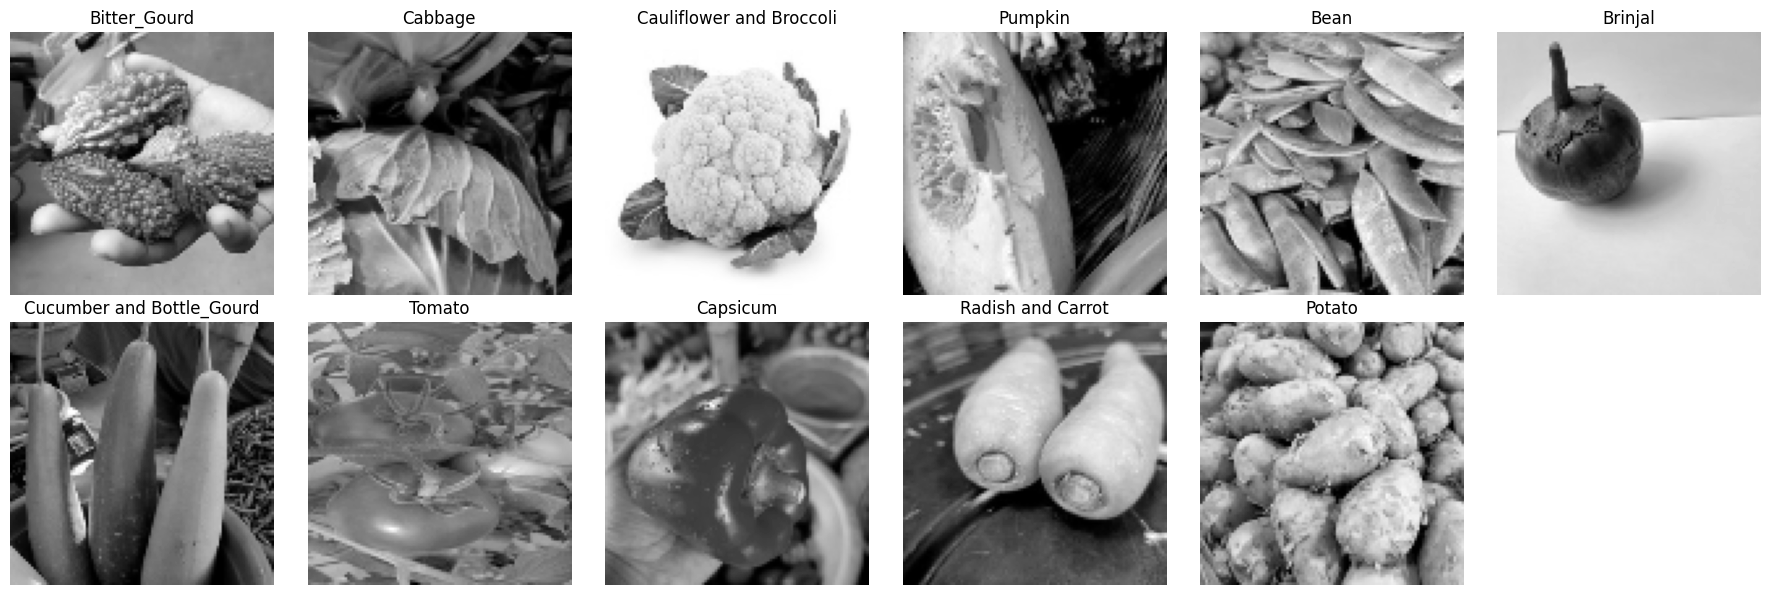

In [7]:
# Show one sample from each class in the unclean training set (101x101) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(unclean_train_101, unclean_train_ds.class_names)

## Data Preparation

In [8]:
# Define clean dataset directories
train_dir = "../Dataset Part A - Clean/train"
val_dir = "../Dataset Part A - Clean/validation"
test_dir = "../Dataset Part A - Clean/test"

In [9]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [10]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)
print(test_ds.class_names)
print(val_ds.class_names)

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [11]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 254.22217)
Class names not available in dataset object


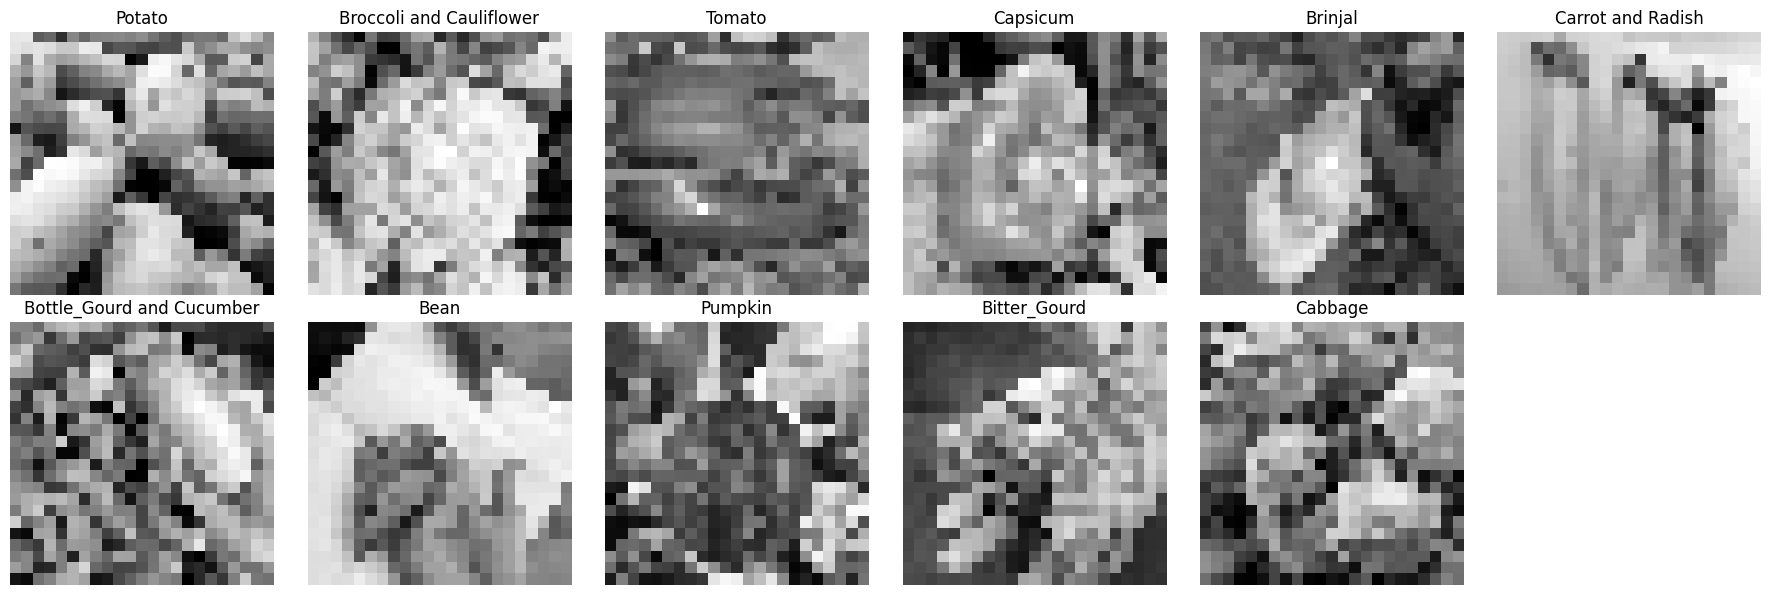

In [12]:
# Show one sample from each class in the training set (23x23) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(train_23, train_ds.class_names)

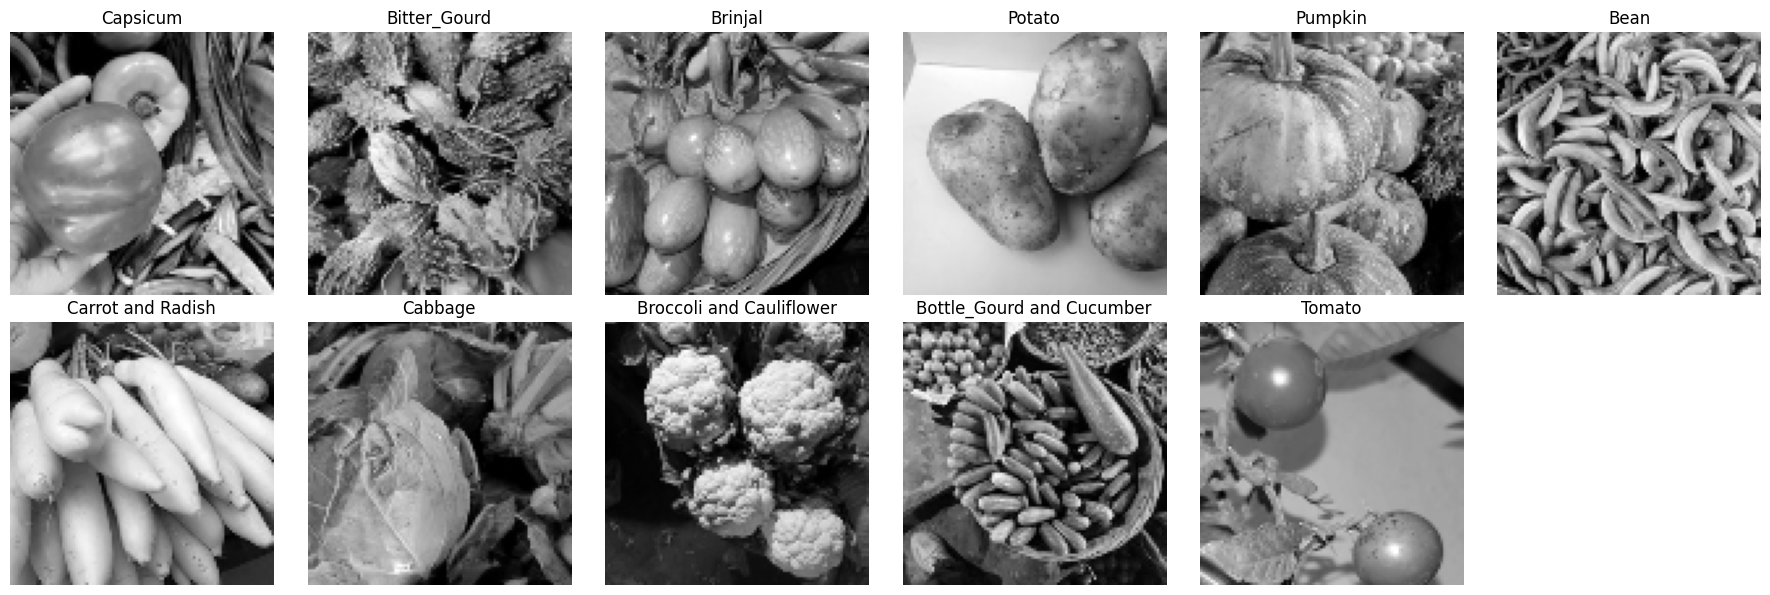

In [13]:
# Show one sample from each class in the training set (101x101) in 2 rows
def show_one_per_class(dataset, class_names):
  shown = set()
  n_classes = len(class_names)
  n_cols = (n_classes + 1) // 2
  plt.figure(figsize=(3 * n_cols, 6))
  idx = 1
  for images, labels in dataset.unbatch():
    label = labels.numpy()
    if label not in shown:
      plt.subplot(2, n_cols, idx)
      plt.imshow(images.numpy().squeeze(), cmap="gray")
      plt.title(f"{class_names[label]}")
      plt.axis("off")
      shown.add(label)
      idx += 1
      if len(shown) == n_classes:
        break
  plt.tight_layout()
  plt.show()

show_one_per_class(train_101, train_ds.class_names)

In [14]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print("Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.9745

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.9745


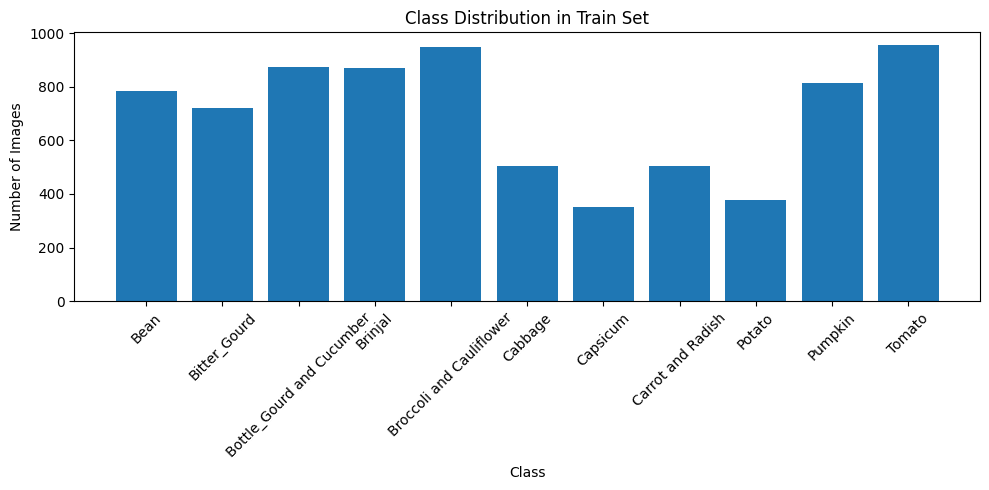

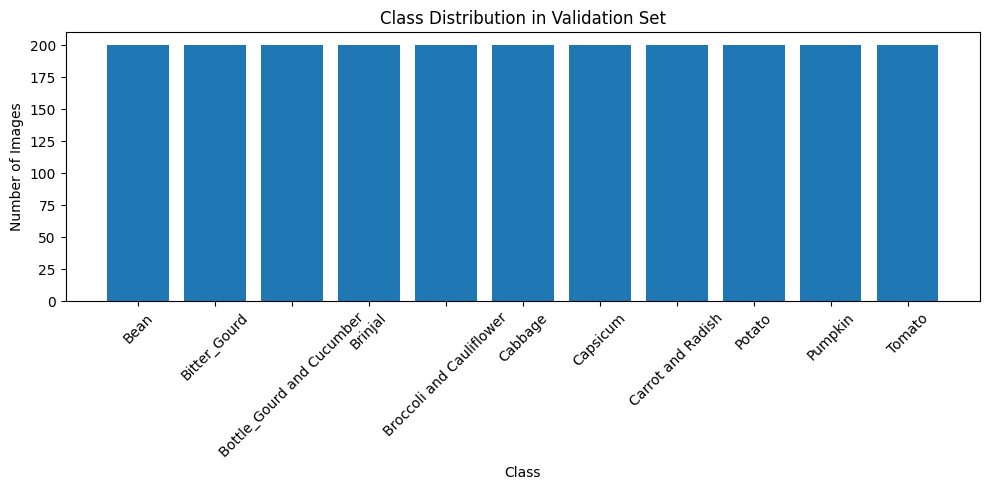

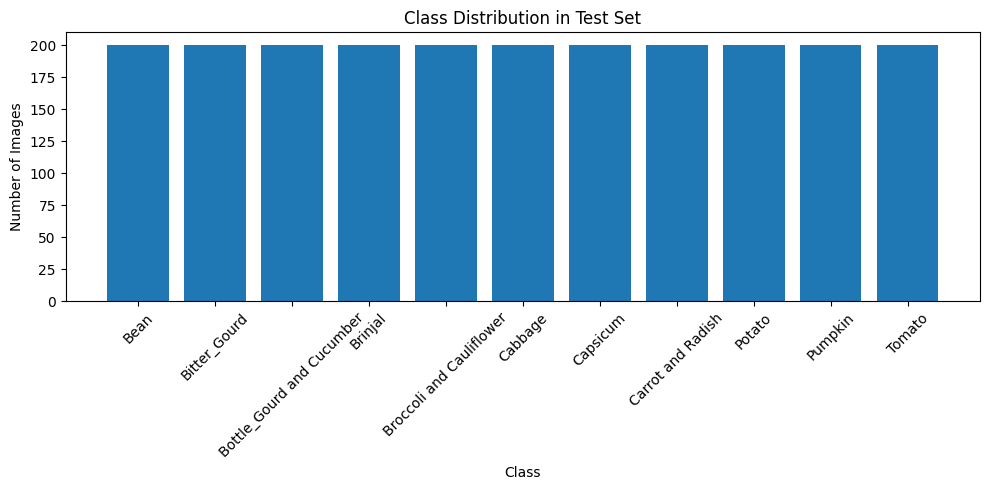

In [15]:
import os
import collections

# Plot class distribution for train, validation, and test sets

def plot_class_distribution(data_dir, set_name):

  class_counts = collections.Counter()
  for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
      count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
      class_counts[class_name] = count

  plt.figure(figsize=(10, 5))
  plt.bar(class_counts.keys(), class_counts.values())
  plt.title(f'Class Distribution in {set_name} Set')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

plot_class_distribution(train_dir, "Train")
plot_class_distribution(val_dir, "Validation")
plot_class_distribution(test_dir, "Test")

## Fully Connected Model (Baseline)

In [16]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 8s 17ms/step - loss: 15.2808 - accuracy: 0.1168 - val_loss: 2.4149 - val_accuracy: 0.0914
Epoch 2/50
241/241 [==============================] - 4s 18ms/step - loss: 2.3742 - accuracy: 0.1225 - val_loss: 2.4127 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3581 - accuracy: 0.1178 - val_loss: 2.4227 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 4s 18ms/step - loss: 2.3533 - accuracy: 0.1205 - val_loss: 2.4314 - val_accuracy: 0.0905
Epoch 5/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3512 - accuracy: 0.1238 - val_loss: 2.4381 - val_accuracy: 0.0905
Epoch 6/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3485 - accuracy: 0.1240 - val_loss: 2.4434 - val_accuracy: 0.0905
Epoch 7/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3487 - accuracy: 0.1239 - va

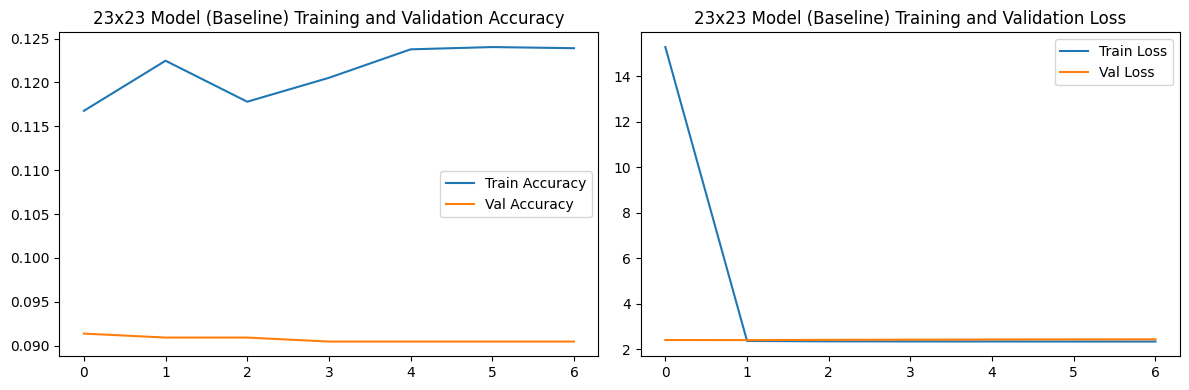

69/69 [==============================] - 1s 13ms/step - loss: 2.4484 - accuracy: 0.0923
23x23 Model (Baseline) - Test Accuracy: 0.0923
23x23 Model (Baseline) - Test Loss: 2.4484

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 5s 18ms/step - loss: 34.6246 - accuracy: 0.1196 - val_loss: 2.4044 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 4s 17ms/step - loss: 2.4136 - accuracy: 0.1256 - val_loss: 2.4158 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3551 - accuracy: 0.1227 - val_loss: 2.4262 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3529 - accuracy: 0.1200 - val_loss: 2.4329 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 4s 17ms/step - loss: 2.3501 - accuracy: 0.1226 - val_loss: 2.4387 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 4s 17ms/step -

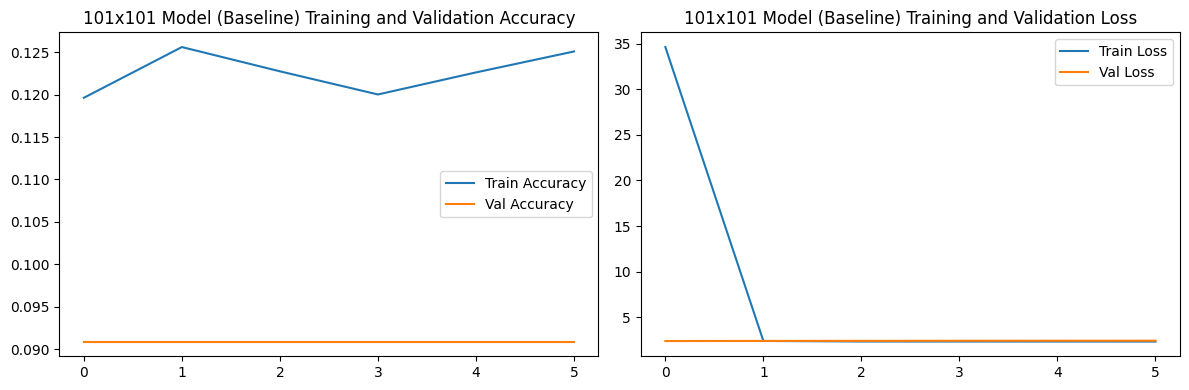

69/69 [==============================] - 1s 13ms/step - loss: 2.4429 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4429


In [17]:
# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")

1/1 [==============================] - 0s 68ms/step


<Figure size 800x600 with 0 Axes>

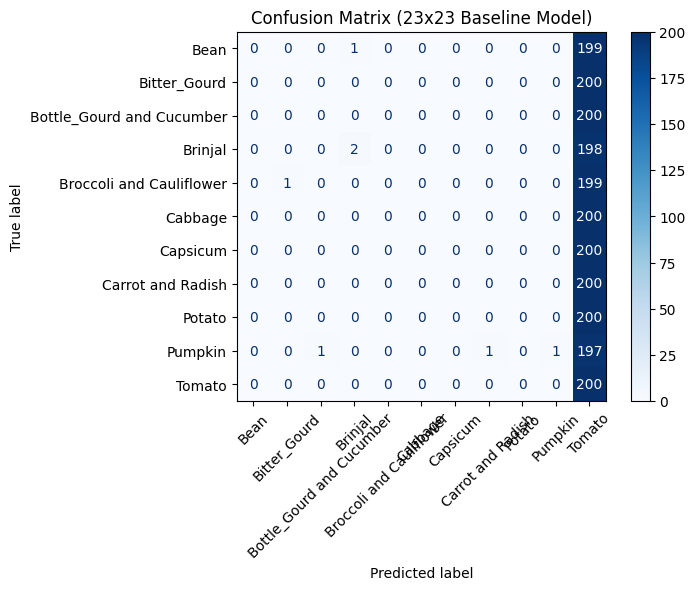

In [18]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = fc_baseline_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Baseline Model)")
plt.show()

1/1 [==============================] - 0s 63ms/step


<Figure size 800x600 with 0 Axes>

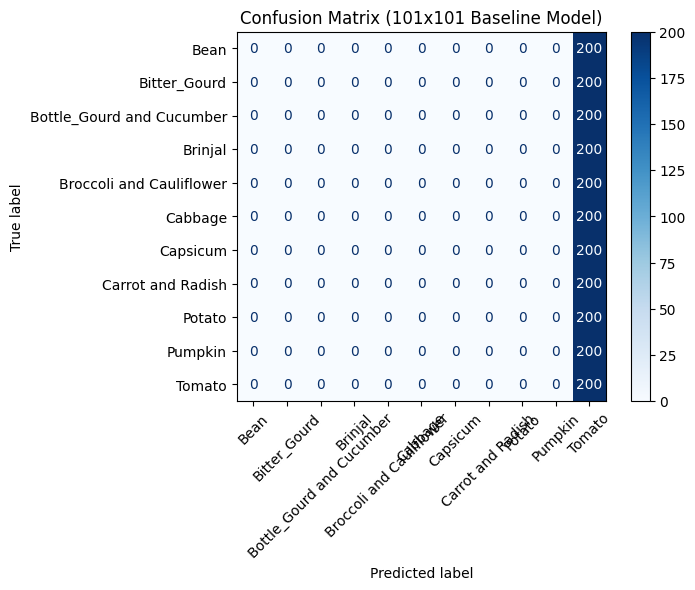

In [19]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = fc_baseline_model_101.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Baseline Model)")
plt.show()

## Training CNN Models

In [20]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [21]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...
Epoch 1/50
241/241 [==============================] - 13s 17ms/step - loss: 2.7279 - accuracy: 0.1712 - val_loss: 2.1745 - val_accuracy: 0.2345
Epoch 2/50
241/241 [==============================] - 4s 18ms/step - loss: 2.0810 - accuracy: 0.2686 - val_loss: 1.9127 - val_accuracy: 0.3482
Epoch 3/50
241/241 [==============================] - 4s 17ms/step - loss: 1.8520 - accuracy: 0.3530 - val_loss: 1.8201 - val_accuracy: 0.3777
Epoch 4/50
241/241 [==============================] - 4s 18ms/step - loss: 1.6783 - accuracy: 0.4286 - val_loss: 1.5712 - val_accuracy: 0.4555
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 1.5055 - accuracy: 0.4864 - val_loss: 1.4360 - val_accuracy: 0.5127
Epoch 6/50
241/241 [==============================] - 4s 18ms/step - loss: 1.3200 - accuracy: 0.5505 - val_loss: 1.3742 - val_accuracy: 0.5345
Epoch 7/50
241/241 [==============================] - 4s 18ms/step - loss: 1.2021 - accuracy: 0.5850 - val_loss: 1.22

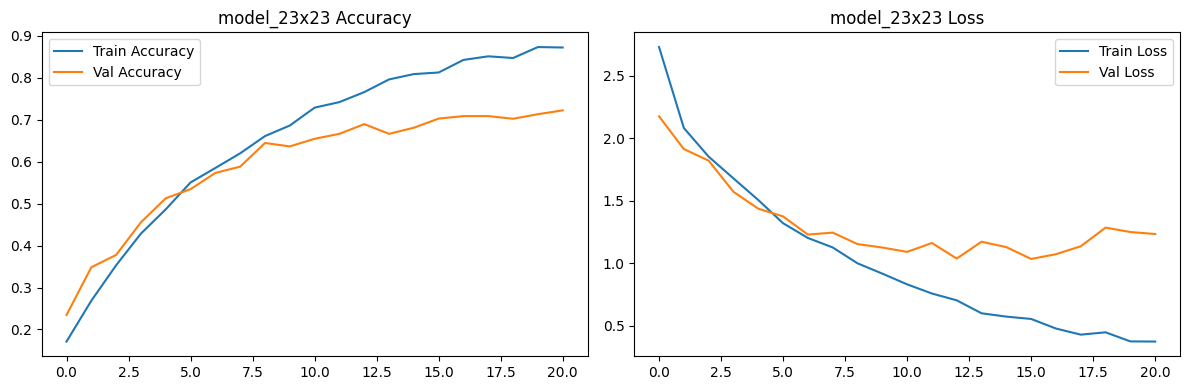

In [22]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")

1/1 [==============================] - 0s 86ms/step


<Figure size 800x600 with 0 Axes>

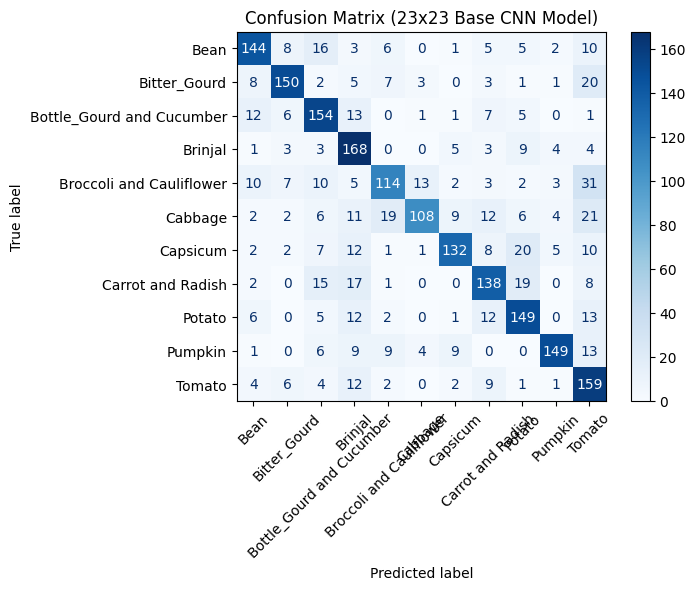

In [23]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Base CNN Model)")
plt.show()


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 9s 35ms/step - loss: 6.1010 - accuracy: 0.1159 - val_loss: 2.4011 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 8s 33ms/step - loss: 2.3692 - accuracy: 0.1191 - val_loss: 2.4092 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 8s 32ms/step - loss: 2.3586 - accuracy: 0.1214 - val_loss: 2.4185 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 8s 33ms/step - loss: 2.3531 - accuracy: 0.1208 - val_loss: 2.4271 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 8s 33ms/step - loss: 2.3502 - accuracy: 0.1217 - val_loss: 2.4341 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 8s 34ms/step - loss: 2.3488 - accuracy: 0.1224 - val_loss: 2.4395 - val_accuracy: 0.0909


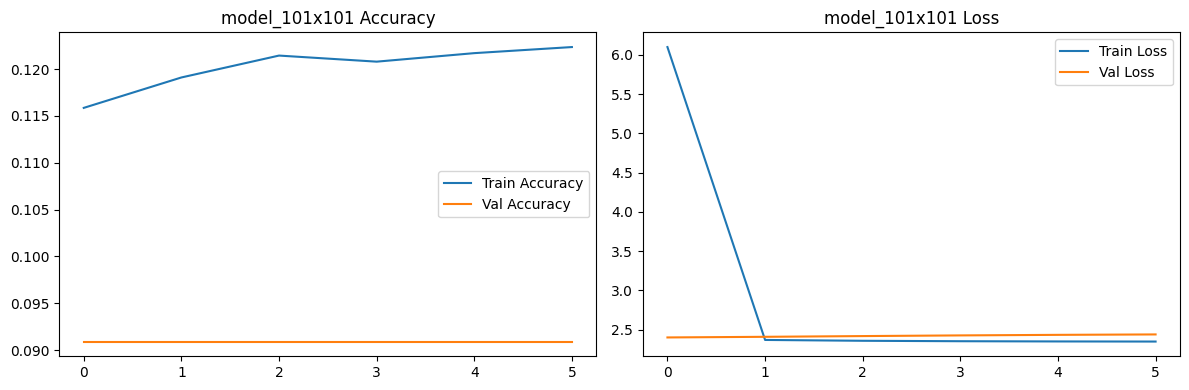

In [24]:
print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

1/1 [==============================] - 0s 125ms/step


<Figure size 800x600 with 0 Axes>

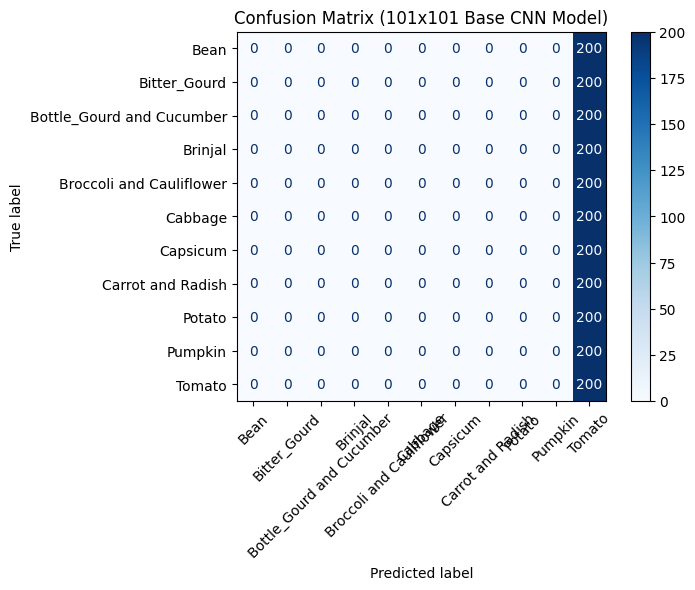

In [25]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = model_101.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Base CNN Model)")
plt.show()

In [26]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy

# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.1173
Test Accuracy: 0.7114
Error Rate: 0.2886

Evaluating 101x101 Model:
Test Loss: 2.4395
Test Accuracy: 0.0909
Error Rate: 0.9091

Accuracy Improvement: -0.6205
Loss Reduction: -1.3222


## Improving the CNN Models

In [27]:
# Define the improved model architecture
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [28]:
# Train the improved model
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model


Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 9s 33ms/step - loss: 1.8633 - accuracy: 0.3736 - val_loss: 2.0393 - val_accuracy: 0.2864
Epoch 2/50
241/241 [==============================] - 8s 32ms/step - loss: 1.2907 - accuracy: 0.5677 - val_loss: 1.2878 - val_accuracy: 0.5632
Epoch 3/50
241/241 [==============================] - 8s 31ms/step - loss: 1.0105 - accuracy: 0.6626 - val_loss: 0.9835 - val_accuracy: 0.6668
Epoch 4/50
241/241 [==============================] - 6s 25ms/step - loss: 0.7970 - accuracy: 0.7363 - val_loss: 0.8690 - val_accuracy: 0.7114
Epoch 5/50
241/241 [==============================] - 5s 19ms/step - loss: 0.6432 - accuracy: 0.7898 - val_loss: 1.0898 - val_accuracy: 0.6536
Epoch 6/50
241/241 [==============================] - 5s 20ms/step - loss: 0.5528 - accuracy: 0.8211 - val_loss: 0.6656 - val_accuracy: 0.7768
Epoch 7/50
241/241 [==============================] - 5s 20ms/step - loss: 0.4472 - accuracy: 0.8563

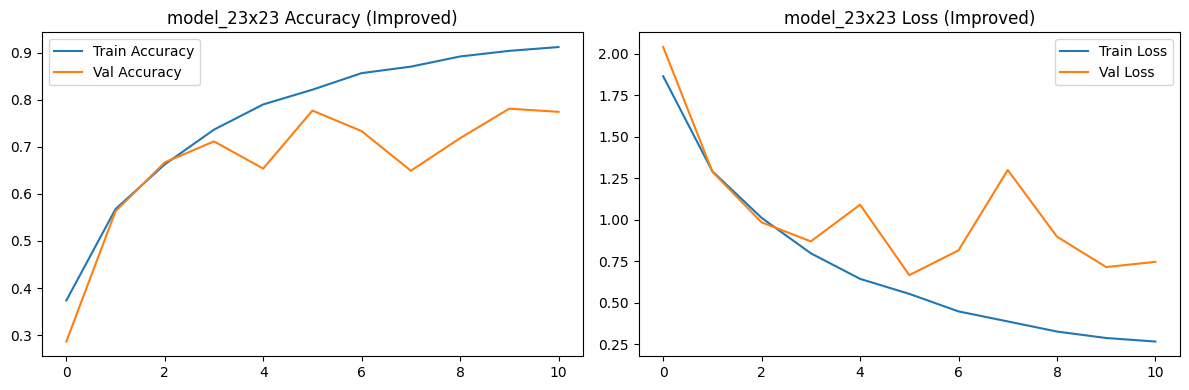


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 9s 34ms/step - loss: 1.6049 - accuracy: 0.4632 - val_loss: 1.6409 - val_accuracy: 0.3800
Epoch 2/50
241/241 [==============================] - 10s 39ms/step - loss: 1.0475 - accuracy: 0.6576 - val_loss: 2.1348 - val_accuracy: 0.3764
Epoch 3/50
241/241 [==============================] - 10s 39ms/step - loss: 0.7456 - accuracy: 0.7549 - val_loss: 5.0213 - val_accuracy: 0.3109
Epoch 4/50
241/241 [==============================] - 9s 38ms/step - loss: 0.5764 - accuracy: 0.8188 - val_loss: 2.1505 - val_accuracy: 0.4141
Epoch 5/50
241/241 [==============================] - 10s 39ms/step - loss: 0.4638 - accuracy: 0.8532 - val_loss: 2.7152 - val_accuracy: 0.5564
Epoch 6/50
241/241 [==============================] - 10s 40ms/step - loss: 0.3874 - accuracy: 0.8779 - val_loss: 2.0721 - val_accuracy: 0.5059


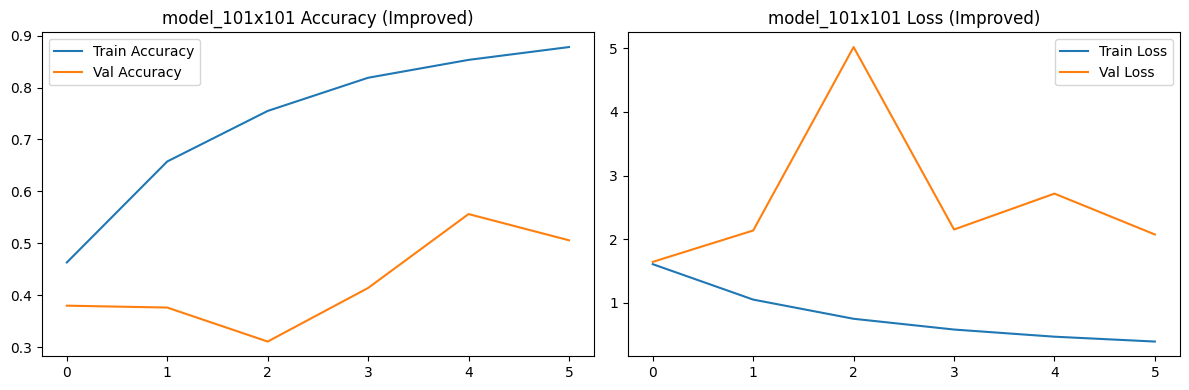

In [29]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")

1/1 [==============================] - 0s 141ms/step


<Figure size 800x600 with 0 Axes>

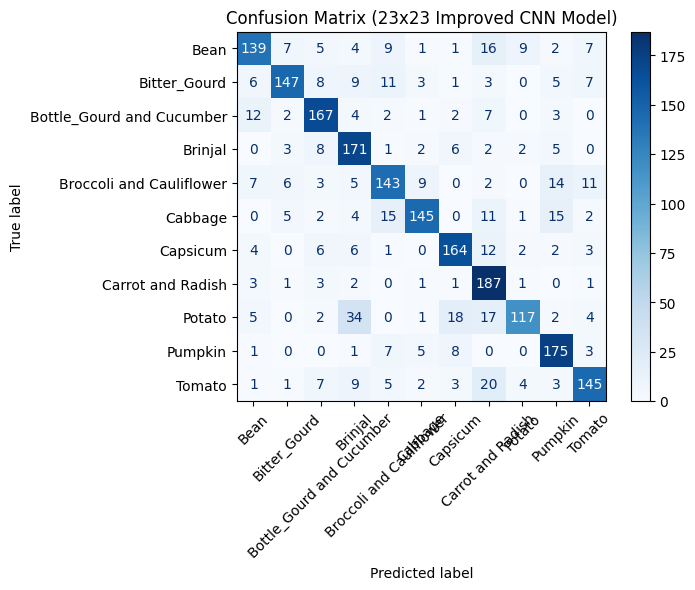

In [30]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = improved_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Improved CNN Model)")
plt.show()

1/1 [==============================] - 0s 39ms/step


<Figure size 800x600 with 0 Axes>

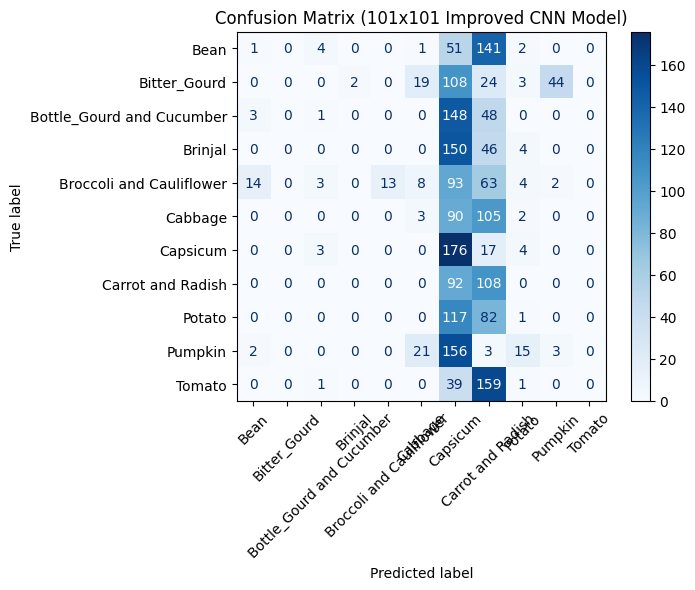

In [31]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = improved_model_23.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Improved CNN Model)")
plt.show()

In [32]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Improved):
Test Loss: 0.6910
Test Accuracy: 0.7727
Error Rate: 0.2273

Evaluating 101x101 Model (Improved):
Test Loss: 1.6458
Test Accuracy: 0.3800
Error Rate: 0.6200

Accuracy Improvement (101x101 - 23x23): -0.3927
Loss Reduction (23x23 - 101x101): -0.9549


## Implement Hyperparameter Tuning for the 23x23 Model

In [33]:
# Define the model-building function for Keras Tuner
def build_23_model_with_hyperparameters(hp):
    tuned_23_model = models.Sequential()
    
    # Conv Layer 1
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    tuned_23_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_23_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_23_model.add(layers.BatchNormalization())
    
    tuned_23_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_23_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_23_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_23_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_23_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_23_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_23_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_23_model_tuning'
)

Reloading Tuner from kt_dir\improved_23_model_tuning\tuner0.json


In [34]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv_1_filters': 64, 'conv_2_filters': 192, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.5, 'learning_rate': 0.00028745791047186465}


In [35]:
# Build and train the model with the best hyperparameters
tuned_23_model = tuner.hypermodel.build(best_hps)
history = tuned_23_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
241/241 [==============================] - 11s 38ms/step - loss: 1.6763 - accuracy: 0.4464 - val_loss: 1.5386 - val_accuracy: 0.4795
Epoch 2/50
241/241 [==============================] - 9s 34ms/step - loss: 0.9980 - accuracy: 0.6681 - val_loss: 0.9651 - val_accuracy: 0.6909
Epoch 3/50
241/241 [==============================] - 8s 33ms/step - loss: 0.6612 - accuracy: 0.7905 - val_loss: 0.9444 - val_accuracy: 0.7005
Epoch 4/50
241/241 [==============================] - 9s 35ms/step - loss: 0.4481 - accuracy: 0.8589 - val_loss: 0.7763 - val_accuracy: 0.7545
Epoch 5/50
241/241 [==============================] - 8s 34ms/step - loss: 0.2920 - accuracy: 0.9167 - val_loss: 0.5789 - val_accuracy: 0.8268
Epoch 6/50
241/241 [==============================] - 8s 33ms/step - loss: 0.2045 - accuracy: 0.9443 - val_loss: 0.4853 - val_accuracy: 0.8509
Epoch 7/50
241/241 [==============================] - 7s 29ms/step - loss: 0.1536 - accuracy: 0.9549 - val_loss: 0.8984 - val_accuracy: 0.725

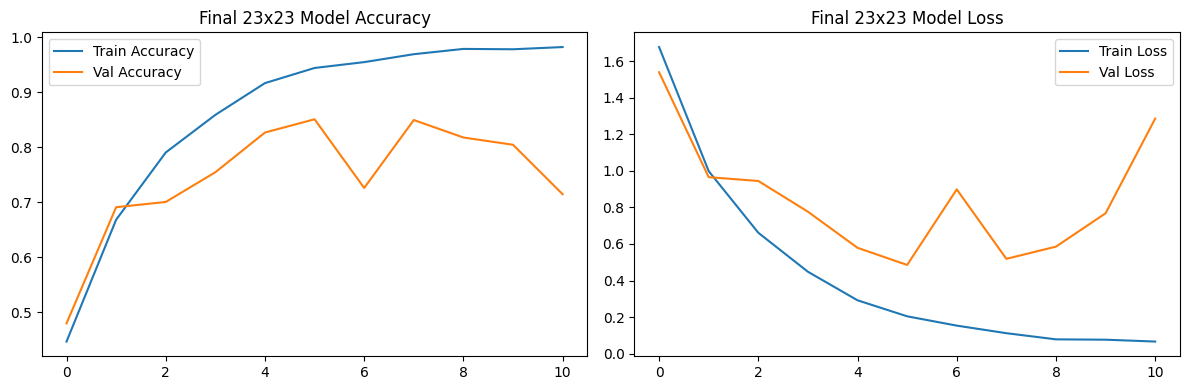

In [36]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Final 23x23 Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Final 23x23 Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("tuned_23_model.png")
plt.show()

1/1 [==============================] - 0s 113ms/step


<Figure size 800x600 with 0 Axes>

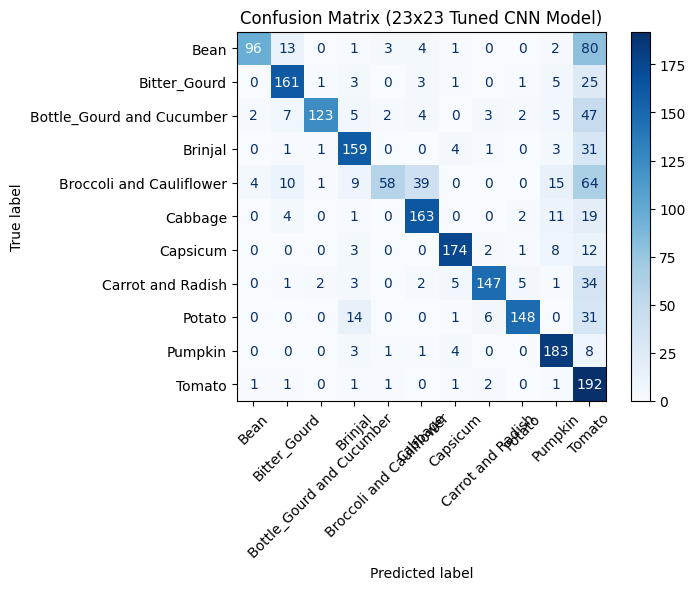

In [37]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_23:
  preds = tuned_23_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (23x23 Tuned CNN Model)")
plt.show()

In [38]:
# Evaluate the best model
test_loss, test_acc = tuned_23_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 [==============================] - 1s 13ms/step - loss: 1.2168 - accuracy: 0.7291
Test Accuracy: 0.7291
Test Loss: 1.2168


## Implement Hyperparameter Tuning for the 101x101 Model

In [39]:
# Define the model-building function for Keras Tuner
def build_101_model_with_hyperparameters(hp):
    tuned_101_model = models.Sequential()
    
    # Conv Layer 1
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(101, 101, 1)
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    tuned_101_model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    tuned_101_model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    tuned_101_model.add(layers.BatchNormalization())
    
    tuned_101_model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    tuned_101_model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    tuned_101_model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    tuned_101_model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    tuned_101_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return tuned_101_model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_101_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_101_model_tuning'
)

Reloading Tuner from kt_dir\improved_101_model_tuning\tuner0.json


In [40]:
# Run hyperparameter tuning
tuner.search(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv_1_filters': 96, 'conv_2_filters': 256, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.4, 'learning_rate': 2.6233713088320727e-05}


In [41]:
# Build and train the model with the best hyperparameters
tuned_101_model = tuner.hypermodel.build(best_hps)
history = tuned_101_model.fit(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
241/241 [==============================] - 24s 88ms/step - loss: 1.8491 - accuracy: 0.3988 - val_loss: 1.8237 - val_accuracy: 0.3577
Epoch 2/50
241/241 [==============================] - 21s 85ms/step - loss: 1.4400 - accuracy: 0.5529 - val_loss: 1.3655 - val_accuracy: 0.5614
Epoch 3/50
241/241 [==============================] - 21s 84ms/step - loss: 1.2418 - accuracy: 0.6205 - val_loss: 1.2156 - val_accuracy: 0.6232
Epoch 4/50
241/241 [==============================] - 20s 83ms/step - loss: 1.0792 - accuracy: 0.6872 - val_loss: 1.0621 - val_accuracy: 0.6864
Epoch 5/50
241/241 [==============================] - 20s 83ms/step - loss: 0.9630 - accuracy: 0.7165 - val_loss: 0.9055 - val_accuracy: 0.7332
Epoch 6/50
241/241 [==============================] - 21s 84ms/step - loss: 0.8636 - accuracy: 0.7509 - val_loss: 0.7989 - val_accuracy: 0.7573
Epoch 7/50
241/241 [==============================] - 20s 84ms/step - loss: 0.7808 - accuracy: 0.7788 - val_loss: 0.7051 - val_accuracy:

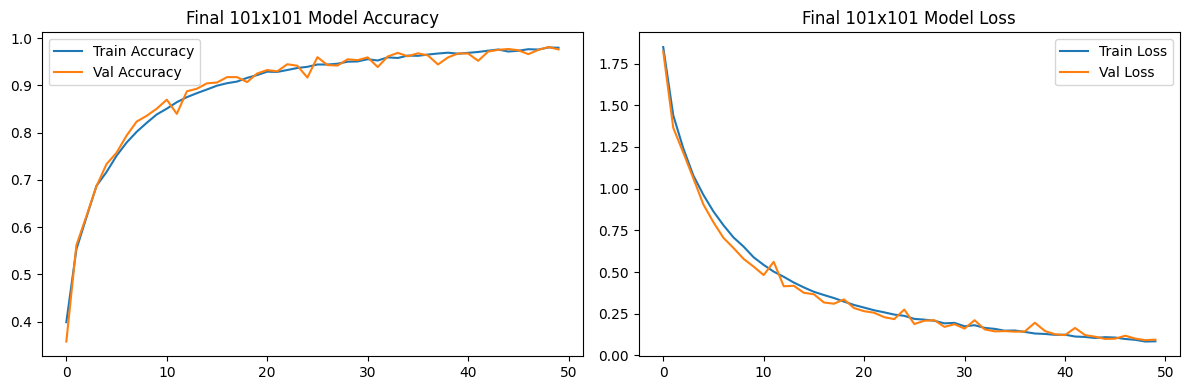

In [42]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Final 101x101 Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Final 101x101 Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("tuned_101_model.png")
plt.show()

1/1 [==============================] - 0s 151ms/step


<Figure size 800x600 with 0 Axes>

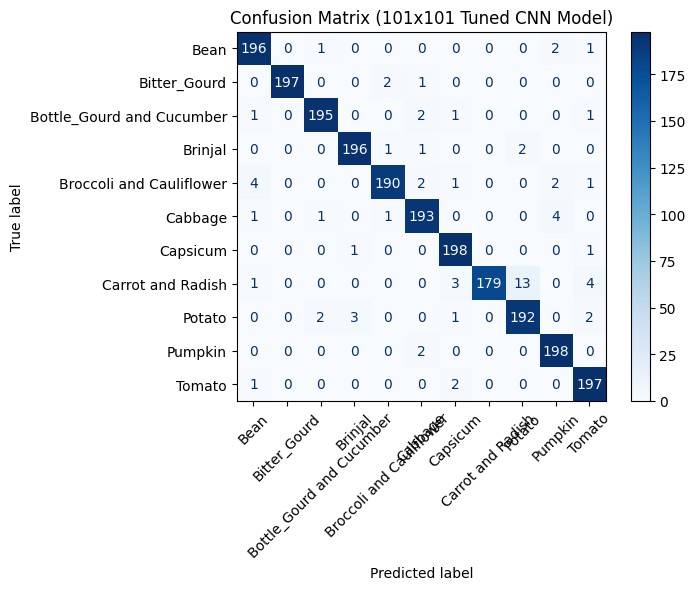

In [43]:
# Get true labels and predictions for the test set (23x23 baseline model as example)
y_true = []
y_pred = []

for images, labels in test_101:
  preds = tuned_101_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (101x101 Tuned CNN Model)")
plt.show()

In [44]:
# Evaluate the best model
test_loss, test_acc = tuned_101_model.evaluate(test_101)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

69/69 [==============================] - 3s 35ms/step - loss: 0.1043 - accuracy: 0.9686
Test Accuracy: 0.9686
Test Loss: 0.1043


## Compare all the models

In [45]:
# Evaluate the base CNN model's Performance
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy

# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.1173
Test Accuracy: 0.7114
Error Rate: 0.2886

Evaluating 101x101 Model:
Test Loss: 2.4395
Test Accuracy: 0.0909
Error Rate: 0.9091

Accuracy Improvement: -0.6205
Loss Reduction: -1.3222


In [46]:
# Evaluate the improved model's performance
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Improved):
Test Loss: 0.6910
Test Accuracy: 0.7727
Error Rate: 0.2273

Evaluating 101x101 Model (Improved):
Test Loss: 1.6458
Test Accuracy: 0.3800
Error Rate: 0.6200

Accuracy Improvement (101x101 - 23x23): -0.3927
Loss Reduction (23x23 - 101x101): -0.9549


In [48]:
# Evaluate the tuned model's performance
def evaluate_tuned_model(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Final):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy

# Evaluate tuned models
loss_23_tuned, acc_23_tuned = evaluate_tuned_model(tuned_23_model, test_23, "23x23 Model")
loss_101_tuned, acc_101_tuned = evaluate_tuned_model(tuned_101_model, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")


Evaluating 23x23 Model (Final):
Test Loss: 1.2168
Test Accuracy: 0.7291
Error Rate: 0.2709

Evaluating 101x101 Model (Final):
Test Loss: 0.1043
Test Accuracy: 0.9686
Error Rate: 0.0314

Accuracy Improvement (101x101 - 23x23): -0.3927
Loss Reduction (23x23 - 101x101): -0.9549
